In [373]:
# Import packages
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import ensemble
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer

In [2]:
pd.set_option('display.max_columns', 600)
pd.set_option('display.max_rows', 600)

In [3]:
temp_data = pickle.load(open("temp_Data.p", "rb" ))

In [4]:
# Original Data

X = temp_data.loc[:, temp_data.columns != 'loan_status']
y = temp_data.loc[:, temp_data.columns == 'loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size = 0.2,
                                                   shuffle = True,
                                                   random_state = 111,
                                                   stratify = y)
print("Original data shapes: {}, {}".format(X_train.shape, X_test.shape))

Original data shapes: (1803484, 158), (450871, 158)


In [5]:
# Importing Important Features

important_features = pd.read_csv('important_features.csv')

In [6]:
X_train_important = X_train[important_features.iloc[:22,1]]
X_test_important = X_test[important_features.iloc[:22,1]]

In [7]:
# Imputing with strategy "Median"
imp = SimpleImputer(strategy='median')
imp.fit(X_train_important)
X_train_scaled = imp.transform(X_train_important)
X_test_scaled = imp.transform(X_test_important)

In [8]:
from sklearn.preprocessing import StandardScaler

# Standardizing the data
standardize = StandardScaler()
standardize.fit(X_train_scaled)
X_train_scaled = standardize.transform(X_train_scaled)
X_test_scaled = standardize.transform(X_test_scaled)

In [9]:
imp_feats_cols = important_features['Features'].to_list()

In [15]:
# Parameters were chose from the results table to use in the better model
parameters_bm = {'n_estimators': 200,'max_features': 'sqrt','max_leaf_nodes': 7,
                  'learning_rate': 0.3, 'min_samples_split': 0.1, 'random_state': 1}

better_model = ensemble.GradientBoostingClassifier(**parameters_bm)
better_estimator = better_model.fit(X_train_scaled, y_train.values.ravel())
better_estimator
bm_auc_score = roc_auc_score(y_test.values.ravel(), better_model.predict_proba(X_test_scaled)[:,1])

print("The Better Model has an AUC (Test_Set) Score of: {}".format(bm_auc_score))

The Better Model has an AUC (Test_Set) Score of: 0.7274804086926439


In [18]:
prob_classes = pd.DataFrame()
prob_classes['Y']= y_test.values.ravel()
prob_classes['Class: No Delinquency'] = better_estimator.predict_proba(X_test_scaled)[:, 0]
prob_classes['Class: Delinquent'] = better_estimator.predict_proba(X_test_scaled)[:, 1]

In [67]:
default_prob_GBM = pd.DataFrame(index=y_test.index)
default_prob_GBM['Y'] = prob_classes['Y'].to_list()
default_prob_GBM['Prob_Current'] = prob_classes['Class: No Delinquency'].to_list()
default_prob_GBM['Prob_Default'] = prob_classes['Class: Delinquent'].to_list()
default_prob_GBM.head(50)

,Y,Prob_Current,Prob_Default
765198,0,0.653576,0.346424
1653649,0,0.931997,0.068003
2125192,0,0.756274,0.243726
1212833,0,0.900419,0.099581
369055,0,0.810285,0.189715
1425916,0,0.933957,0.066043
684179,1,0.930032,0.069968
857297,0,0.850333,0.149667
1501349,0,0.947194,0.052806
996374,1,0.723713,0.276287


In [69]:
bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
labels = [0,10,20,30,40,50,60,70,80,90,100]
default_prob_GBM['Buckets'] = pd.cut(default_prob_GBM['Prob_Default'],bins= bins)
default_prob_GBM.head(50)

,Y,Prob_Current,Prob_Default,Buckets
765198,0,0.653576,0.346424,"(0.3, 0.4]"
1653649,0,0.931997,0.068003,"(0.0, 0.1]"
2125192,0,0.756274,0.243726,"(0.2, 0.3]"
1212833,0,0.900419,0.099581,"(0.0, 0.1]"
369055,0,0.810285,0.189715,"(0.1, 0.2]"
1425916,0,0.933957,0.066043,"(0.0, 0.1]"
684179,1,0.930032,0.069968,"(0.0, 0.1]"
857297,0,0.850333,0.149667,"(0.1, 0.2]"
1501349,0,0.947194,0.052806,"(0.0, 0.1]"
996374,1,0.723713,0.276287,"(0.2, 0.3]"


In [70]:
default_prob_GBM['Buckets'].value_counts()

(0.0, 0.1]    204023
(0.1, 0.2]    161285
(0.2, 0.3]     55342
(0.3, 0.4]     20063
(0.4, 0.5]      7130
(0.5, 0.6]      1811
(0.6, 0.7]       397
(0.9, 1.0]       394
(0.8, 0.9]       220
(0.7, 0.8]       206
Name: Buckets, dtype: int64

In [91]:
default_prob_GBM.groupby('Buckets')['Y'].apply(lambda x: round((x.value_counts()[1] / 
                                                                (x.value_counts()[0] + 
                                                                 x.value_counts()[1]))*100,1))

Buckets
(0.0, 0.1]     5.5
(0.1, 0.2]    14.3
(0.2, 0.3]    24.5
(0.3, 0.4]    34.3
(0.4, 0.5]    43.0
(0.5, 0.6]    50.7
(0.6, 0.7]    58.9
(0.7, 0.8]    65.0
(0.8, 0.9]    87.7
(0.9, 1.0]    94.2
Name: Y, dtype: float64

In [111]:
# Calculating the Bad Rate in each group
def_prob_GBM = pd.DataFrame(default_prob_GBM.groupby('Buckets')['Y'].apply(lambda x: round((x.value_counts()[1] / 
                                                                            (x.value_counts()[0] + 
                                                                             x.value_counts()[1])),5)))
def_prob_GBM.rename(columns={'Y':'Bad Rate %'}, inplace = True)

In [336]:
# Calculating the interest rate that each group should be charged

# Step 1: Find the average default probability in each group

def_prob_GBM['Avg Default Prob'] = [round(i,5) 
                                    for i in default_prob_GBM.groupby('Buckets')['Prob_Default'].mean().to_list()]

# Step 2: Calculate the Interest Rate that each group should be charged (Provided Risk Free Rate = 2%)
# 1 - [(1 + rf) / (Probability of No Default)]

def_prob_GBM['Relevant IR'] = ((1+0.02) / (1 - def_prob_GBM['Bad Rate %'])).values - 1

In [337]:
def_prob_GBM

,Bad Rate %,Avg Default Prob,Relevant IR
Buckets,,,
"(0.0, 0.1]",0.05509,0.05559,0.079468
"(0.1, 0.2]",0.14316,0.14274,0.190421
"(0.2, 0.3]",0.24526,0.24062,0.351459
"(0.3, 0.4]",0.34317,0.34266,0.552913
"(0.4, 0.5]",0.43029,0.44021,0.790385
"(0.5, 0.6]",0.50745,0.53763,1.070856
"(0.6, 0.7]",0.58942,0.63930,1.484291
"(0.7, 0.8]",0.65049,0.74550,1.918371
"(0.8, 0.9]",0.87727,0.85164,7.310926


In [338]:
def_prob_GBM['Relevant IR']

Buckets
(0.0, 0.1]     0.079468
(0.1, 0.2]     0.190421
(0.2, 0.3]     0.351459
(0.3, 0.4]     0.552913
(0.4, 0.5]     0.790385
(0.5, 0.6]     1.070856
(0.6, 0.7]     1.484291
(0.7, 0.8]     1.918371
(0.8, 0.9]     7.310926
(0.9, 1.0]    16.471737
Name: Relevant IR, dtype: float64

In [339]:
#def_prob_GBM.to_csv('def_prob_GBM.csv')

##  Question 3

In [243]:
#with open("loan.pickle", "rb") as f:
#    loan_dat = pickle.load(f)

In [340]:
default_prob_GBM

,Y,Prob_Current,Prob_Default,Buckets,Term Months,Loan Amount,Loan Payment,Bad Rate %,Avg Default Prob,Relevant IR
765198,0,0.653576,0.346424,"(0.3, 0.4]",60,30000,18621.19,0.34317,0.34266,0.551708
1653649,0,0.931997,0.068003,"(0.0, 0.1]",36,4300,1668.66,0.05509,0.05559,0.080039
2125192,0,0.756274,0.243726,"(0.2, 0.3]",36,10000,5843.17,0.24526,0.24062,0.343201
1212833,0,0.900419,0.099581,"(0.0, 0.1]",60,35000,8766.89,0.05509,0.05559,0.080039
369055,0,0.810285,0.189715,"(0.1, 0.2]",60,30000,9807.94,0.14316,0.14274,0.189837
...,...,...,...,...,...,...,...,...,...,...
1648878,0,0.877735,0.122265,"(0.1, 0.2]",36,3000,1401.56,0.14316,0.14274,0.189837
603123,0,0.899481,0.100519,"(0.1, 0.2]",36,14000,6540.63,0.14316,0.14274,0.189837
2130333,0,0.898264,0.101736,"(0.1, 0.2]",36,18000,8409.38,0.14316,0.14274,0.189837
675659,0,0.892615,0.107385,"(0.1, 0.2]",36,12000,5606.25,0.14316,0.14274,0.189837


In [342]:
default_prob_GBM.drop(columns=['Bad Rate %', 'Avg Default Prob', 'Relevant IR'],inplace=True)

In [343]:
# Getting the information we need (Loan Amount, Term)

default_prob_GBM['Term Months'] = loan_dat['term']
default_prob_GBM['Loan Amount'] = loan_dat['loan_amnt']

mapping_term = {' 36 months': 36, 
                ' 60 months': 60}
default_prob_GBM.replace(mapping_term, inplace=True)

# Getting the Relevant Interest Rates per Default group onto our main data set.
default_prob_GBM = default_prob_GBM.join(def_prob_GBM, on='Buckets')

In [344]:
#default_prob_GBM.to_csv('default_prob_GBM.csv')

In [345]:
def loan_payment(relevant_rate, loan_amount, term):
    rate = relevant_rate
    pv = loan_amount
    n = term / 12
    
    payment = (rate * pv) / (1-((1+rate)**-n))
    return round(payment,2)

In [346]:
default_prob_GBM['Loan Payment'] = loan_payment(default_prob_GBM['Relevant IR'], 
                                                default_prob_GBM['Loan Amount'], 
                                                default_prob_GBM['Term Months'])

In [362]:
default_prob_GBM

,Y,Prob_Current,Prob_Default,Buckets,Term Months,Loan Amount,Loan Payment,Bad Rate %,Avg Default Prob,Relevant IR,Expected NPV
765198,0,0.653576,0.346424,"(0.3, 0.4]",60,30000,18652.82,0.34317,0.34266,0.552913,3321.89
1653649,0,0.931997,0.068003,"(0.0, 0.1]",36,4300,1666.94,0.05509,0.05559,0.079468,3418.52
2125192,0,0.756274,0.243726,"(0.2, 0.3]",36,10000,5908.14,0.24526,0.24062,0.351459,4051.28


## Question 4

In [352]:
def npv_calculator(loan_amount, bad_rate, loan_payment, term, discount_rate):
    
    nodef_prob = 1 - bad_rate
    cf = loan_payment
    n = int(term / 12.0)
    rf = discount_rate

    pv_cf = 0
    
    for i in range(1, (n + 1)):
        if i != n:
            pv_cf += ((nodef_prob**i) * cf) / (1 + rf)**i
            
        else:
            pv_cf += ((nodef_prob**i) * (loan_amount + cf)) / (1 + rf)**i
            
    return round((pv_cf - loan_amount), 2)

In [355]:
default_prob_GBM_copy = default_prob_GBM.copy()

In [359]:
for i in default_prob_GBM.index:
    default_prob_GBM.loc[i, 'Expected NPV'] = npv_calculator(default_prob_GBM.loc[i,'Loan Amount'],
                                                             default_prob_GBM.loc[i,'Bad Rate %'],
                                                             default_prob_GBM.loc[i,'Loan Payment'],
                                                             default_prob_GBM.loc[i,'Term Months'], 
                                                             discount_rate=0.02)

In [361]:
#default_prob_GBM.to_csv('default_prob_GBM.csv')

In [383]:
default_prob_GBM.head(7)

,Y,Prob_Current,Prob_Default,Buckets,Term Months,Loan Amount,Loan Payment,Bad Rate %,Avg Default Prob,Relevant IR,Expected NPV
765198,0,0.653576,0.346424,"(0.3, 0.4]",60,30000,18652.82,0.34317,0.34266,0.552913,3321.89
1653649,0,0.931997,0.068003,"(0.0, 0.1]",36,4300,1666.94,0.05509,0.05559,0.079468,3418.52
2125192,0,0.756274,0.243726,"(0.2, 0.3]",36,10000,5908.14,0.24526,0.24062,0.351459,4051.28
1212833,0,0.900419,0.099581,"(0.0, 0.1]",60,35000,8753.69,0.05509,0.05559,0.079468,23879.20
369055,0,0.810285,0.189715,"(0.1, 0.2]",60,30000,9820.72,0.14316,0.14274,0.190421,12549.29
1425916,0,0.933957,0.066043,"(0.0, 0.1]",60,40000,10004.21,0.05509,0.05559,0.079468,27290.48
684179,1,0.930032,0.069968,"(0.0, 0.1]",36,12000,4651.93,0.05509,0.05559,0.079468,9540.08


## Question 5

In [366]:
badrate_NPV = pd.DataFrame(default_prob_GBM.groupby('Buckets')['Expected NPV'].sum())

In [370]:
badrate_NPV['Bad Rate'] = def_prob_GBM['Bad Rate %']

In [371]:
badrate_NPV

,Expected NPV,Bad Rate
Buckets,,
"(0.0, 0.1]",2.272110e+09,0.05509
"(0.1, 0.2]",1.229138e+09,0.14316
"(0.2, 0.3]",2.678931e+08,0.24526
"(0.3, 0.4]",5.535458e+07,0.34317
"(0.4, 0.5]",1.031936e+07,0.43029
"(0.5, 0.6]",1.431628e+06,0.50745
"(0.6, 0.7]",1.921582e+05,0.58942
"(0.7, 0.8]",6.889527e+04,0.65049
"(0.8, 0.9]",2.848240e+03,0.87727


Text(0.5, 1.0, 'Expected NPV vs. Bad Rate')

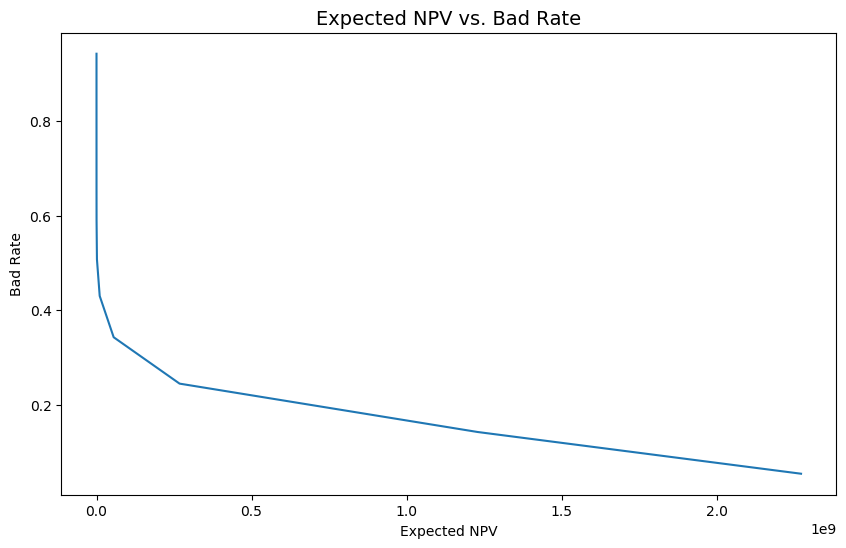

In [387]:
plt.style.use('default')
plt.figure(figsize=(10,6))
sns.lineplot(x = 'Expected NPV', y = 'Bad Rate', data= badrate_NPV)
plt.title('Expected NPV vs. Bad Rate', fontsize = 14)